# Jenius
Forecasting for Jenius, digital bank in Indonesia

In [120]:
#import gc
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import statsmodels.api as sm
from matplotlib import pyplot
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn import linear_model
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

random.seed(1)

sns.set(rc={'figure.figsize': (15, 6)})

In [2]:
def reduce_memory_usage(df, verbose=True): 
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] 
    start_mem = df.memory_usage().sum() / 1024**2 
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns: 
        col_type = df[col].dtypes 
        if col_type in numerics: 
            c_min = df[col].min() 
            c_max = df[col].max() 
            if str(col_type)[:3] == 'int': 
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max: 
                    df[col] = df[col].astype(np.int8) 
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max: 
                    df[col] = df[col].astype(np.int16) 
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max: 
                    df[col] = df[col].astype(np.int32) 
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max: 
                    df[col] = df[col].astype(np.int64)   
                else: 
                    if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max: 
                        df[col] = df[col].astype(np.float16) 
                    elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max: 
                        df[col] = df[col].astype(np.float32) 
                    else: 
                        df[col] = df[col].astype(np.float64)     
        end_mem = df.memory_usage().sum() / 1024**2 
        if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem)) 
        return df

In [3]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_weekend'] = (df[source_column].dt.weekday >=5).astype(int)
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    return df

## Exploratory Data Analysis

In [4]:
df_input = pd.read_csv('input/input.csv', sep=';', parse_dates=['buss_date'])
print("{:,} records and {} features in train set.".format(df_input.shape[0], df_input.shape[1]))

df_input = reduce_memory_usage(df_input)

241 records and 2 features in train set.
Starting memory usage:  0.00 MB
Reduced memory usage:  0.00 MB (0.0% reduction)


In [5]:
df_input = create_date_features(df_input, 'buss_date', 'buss')

In [105]:
pd.options.display.float_format = '{:,.0f}'.format
df_input[:3]

,buss_date,balance,buss_year,buss_month,buss_day,buss_hour,buss_weekofyear,buss_dayofweek,buss_weekend,buss_quarter
0,2018-06-01,"934,075,825,517",2018,6,1,0,22,4,0,2
1,2018-06-02,"929,958,070,324",2018,6,2,0,22,5,1,2
2,2018-06-03,"925,557,302,415",2018,6,3,0,22,6,1,2


### Loading public holidays

In [7]:
df_ph = pd.read_csv('input/indonesian_public_holidays_2018-19.csv', sep=';', parse_dates=['date'])
print("{:,} records and {} features in train set.".format(df_ph.shape[0], df_ph.shape[1]))

df_ph = reduce_memory_usage(df_ph)

20 records and 2 features in train set.
Starting memory usage:  0.00 MB
Reduced memory usage:  0.00 MB (0.0% reduction)


In [8]:
df_input_ph = df_input.merge(df_ph, left_on='buss_date', right_on='date', how='left')

In [9]:
df_input.shape, df_input_ph.shape

((241, 10), (241, 12))

In [10]:
df_input_ph['is_holiday'] = df_input_ph['english_name'].isna() == False
df_input_ph.drop(['date', 'english_name'], axis=1, inplace=True)

Combining weekends with national holidays

In [115]:
df_input_ph['is_workday'] = np.logical_or(df_input_ph['buss_dayofweek'] > 4, df_input_ph['is_holiday'])

In [117]:
df_input_ph[['buss_date', 'buss_dayofweek', 'is_holiday', 'is_workday']][:5]

,buss_date,buss_dayofweek,is_holiday,is_workday
0,2018-06-01,4,True,True
1,2018-06-02,5,False,True
2,2018-06-03,6,False,True
3,2018-06-04,0,False,False
4,2018-06-05,1,False,False


In [11]:
df_input_ph['balance_delta'] = df_input_ph['balance'].diff(1)
df_input_ph['moving_avg'] = df_input_ph['balance_delta'].rolling(window=29, min_periods=24, center=True).mean()

In [12]:
df_input_ph['elapsed_days'] = (df_input_ph['buss_date'].dt.date - date(2000, 1, 1)).dt.days

In [13]:
df_input_ph[['buss_date', 'elapsed_days', 'balance', 'balance_delta', 'moving_avg']][0:5]

,buss_date,elapsed_days,balance,balance_delta,moving_avg
0,2018-06-01,6726,"934,075,825,517",nan,nan
1,2018-06-02,6727,"929,958,070,324","-4,117,755,193",nan
2,2018-06-03,6728,"925,557,302,415","-4,400,767,909",nan
3,2018-06-04,6729,"962,233,057,401","36,675,754,986",nan
4,2018-06-05,6730,"967,838,309,834","5,605,252,433",nan


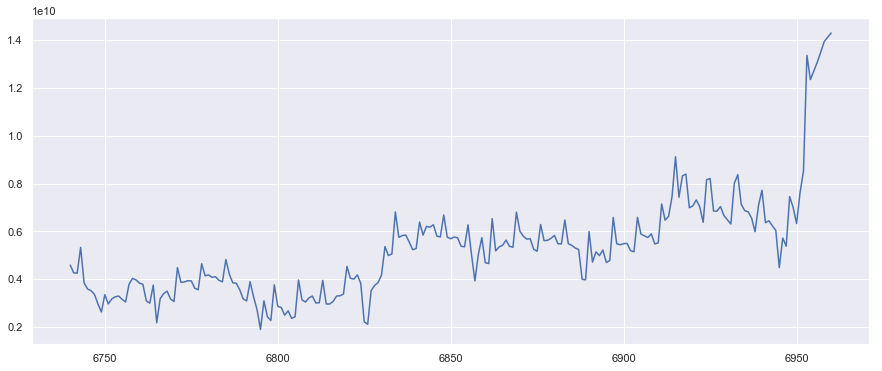

In [123]:
plt.subplot(111)
plt.plot(df_input_ph['elapsed_days'][14:232], df_input_ph['moving_avg'][14:232])

plt.show()

## Regression
### Linear regression

In [14]:
model = sm.OLS(df_input_ph['moving_avg'][14:232], df_input_ph['elapsed_days'][14:232], missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             moving_avg   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1435.
Date:                Thu, 28 Feb 2019   Prob (F-statistic):           1.30e-97
Time:                        15:38:55   Log-Likelihood:                -4980.4
No. Observations:                 218   AIC:                             9963.
Df Residuals:                     217   BIC:                             9966.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
elapsed_days  7.588e+05      2e+04     37.882      0.000    7.19e+05    7.98e+05
==============================================================================
Omnibus:                       93.373   Durbin-Watson:                   0.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              358.740
Skew:                           1.742   Prob(JB):                     1.26e-78
Kurtosis:                       8.230   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
df_input_ph['prediction'] = model.predict(df_input_ph['elapsed_days'])

In [16]:
df_input_ph[['buss_date', 'elapsed_days', 'moving_avg', 'prediction']][0:10]

,buss_date,elapsed_days,moving_avg,prediction
0,2018-06-01,6726,nan,"5,103,659,716"
1,2018-06-02,6727,nan,"5,104,418,512"
2,2018-06-03,6728,nan,"5,105,177,308"
3,2018-06-04,6729,nan,"5,105,936,103"
4,2018-06-05,6730,nan,"5,106,694,899"
5,2018-06-06,6731,nan,"5,107,453,695"
6,2018-06-07,6732,nan,"5,108,212,490"
7,2018-06-08,6733,nan,"5,108,971,286"
8,2018-06-09,6734,nan,"5,109,730,082"
9,2018-06-10,6735,nan,"5,110,488,877"


In [26]:
mse = ((df_input_ph['moving_avg']-df_input_ph['prediction'])**2).sum()/100000000000000
print("MSE: {:,.2f}".format(mse))

MSE: 8,903,454.59


## Time series prediction
Inspired by [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

In [199]:
ma_max = df_input_ph['moving_avg'].max(axis=0)
ma_min = df_input_ph['moving_avg'].min(axis=0)

df_input_ph['moving_avg_norm'] = (df_input_ph['moving_avg'] - ma_min) / (ma_max - ma_min)

In [200]:
df_input_ph['is_workday'] = df_input_ph['is_workday'].map({True: 1, False: 0})

### Univariate LSTM

In [206]:
train_size = int(len(df_input_ph) * 0.67)
test_size = len(df_input_ph) - train_size
train, test = df_input_ph[0:train_size], df_input_ph[train_size:len(df_input_ph)]

In [207]:
len(train), len(test)

(161, 80)

In [208]:
trainX = train['moving_avg_norm']
trainY = train['moving_avg_norm'].shift(-1)

testX = test['moving_avg_norm']
testY = test['moving_avg_norm'].shift(-1)

In [212]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
testX = np.reshape(testX, (testX.shape[0], 1, 1))

In [214]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: nan
Epoch 2/100
 - 0s - loss: nan
Epoch 3/100
 - 0s - loss: nan
Epoch 4/100
 - 0s - loss: nan
Epoch 5/100
 - 0s - loss: nan
Epoch 6/100
 - 0s - loss: nan
Epoch 7/100
 - 0s - loss: nan
Epoch 8/100
 - 0s - loss: nan
Epoch 9/100
 - 0s - loss: nan
Epoch 10/100
 - 0s - loss: nan
Epoch 11/100
 - 0s - loss: nan
Epoch 12/100
 - 0s - loss: nan
Epoch 13/100
 - 0s - loss: nan
Epoch 14/100
 - 0s - loss: nan
Epoch 15/100
 - 0s - loss: nan
Epoch 16/100
 - 0s - loss: nan
Epoch 17/100
 - 0s - loss: nan
Epoch 18/100
 - 0s - loss: nan
Epoch 19/100
 - 0s - loss: nan
Epoch 20/100
 - 0s - loss: nan
Epoch 21/100
 - 0s - loss: nan
Epoch 22/100
 - 0s - loss: nan
Epoch 23/100
 - 0s - loss: nan
Epoch 24/100
 - 0s - loss: nan
Epoch 25/100
 - 0s - loss: nan
Epoch 26/100
 - 0s - loss: nan
Epoch 27/100
 - 0s - loss: nan
Epoch 28/100
 - 0s - loss: nan
Epoch 29/100
 - 0s - loss: nan
Epoch 30/100
 - 0s - loss: nan
Epoch 31/100
 - 0s - loss: nan
Epoch 32/100
 - 0s - loss: nan
Epoch 33/100
 - 0

In [215]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Multivariate LSTM
[Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

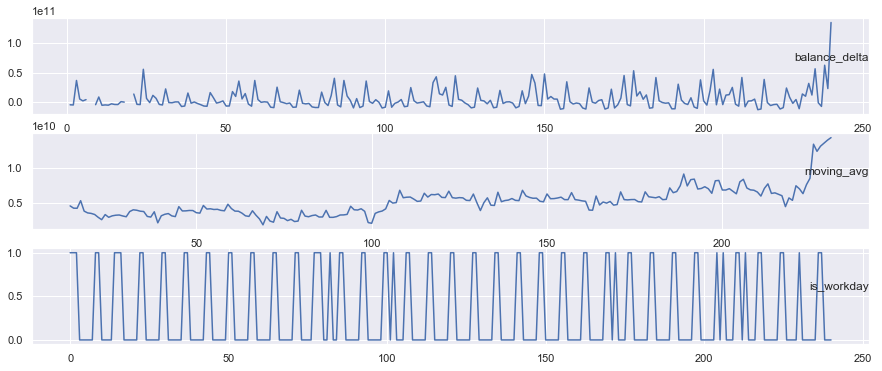

In [122]:
groups = [11, 12, 16]
i = 1

pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(df_input_ph.values[:, group])
    pyplot.title(df_input_ph.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [138]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [146]:
reframed = series_to_supervised(df_input_ph[['elapsed_days', 'is_workday', 'moving_avg_norm']], 1, 1)

In [147]:
reframed[:3]

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
15,6740.00000000,1.00000000,0.21703903,6741,1,0.19086770
16,6741.00000000,1.00000000,0.19086770,6742,1,0.18993382
17,6742.00000000,1.00000000,0.18993382,6743,0,0.27679796


In [173]:
train_size = int(len(df_input_ph) * 0.67)
test_size = len(df_input_ph) - train_size

train = reframed[:train_size].values
test = reframed[test_size:].values

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(161, 1, 5) (161,) (137, 1, 5) (137,)


In [167]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 161 samples, validate on 137 samples
Epoch 1/50
 - 2s - loss: 0.5600 - val_loss: 0.6899
Epoch 2/50
 - 0s - loss: 0.5387 - val_loss: 0.6687
Epoch 3/50
 - 0s - loss: 0.5174 - val_loss: 0.6474
Epoch 4/50
 - 0s - loss: 0.4961 - val_loss: 0.6261
Epoch 5/50
 - 0s - loss: 0.4749 - val_loss: 0.6048
Epoch 6/50
 - 0s - loss: 0.4536 - val_loss: 0.5835
Epoch 7/50
 - 0s - loss: 0.4322 - val_loss: 0.5622
Epoch 8/50
 - 0s - loss: 0.4110 - val_loss: 0.5409
Epoch 9/50
 - 0s - loss: 0.3897 - val_loss: 0.5196
Epoch 10/50
 - 0s - loss: 0.3683 - val_loss: 0.4982
Epoch 11/50
 - 0s - loss: 0.3470 - val_loss: 0.4769
Epoch 12/50
 - 0s - loss: 0.3257 - val_loss: 0.4556
Epoch 13/50
 - 0s - loss: 0.3043 - val_loss: 0.4341
Epoch 14/50
 - 0s - loss: 0.2829 - val_loss: 0.4129
Epoch 15/50
 - 0s - loss: 0.2616 - val_loss: 0.3916
Epoch 16/50
 - 0s - loss: 0.2403 - val_loss: 0.3703
Epoch 17/50
 - 0s - loss: 0.2191 - val_loss: 0.3490
Epoch 18/50
 - 0s - loss: 0.1978 - val_loss: 0.3277
Epoch 19/50
 - 0s - loss: 0

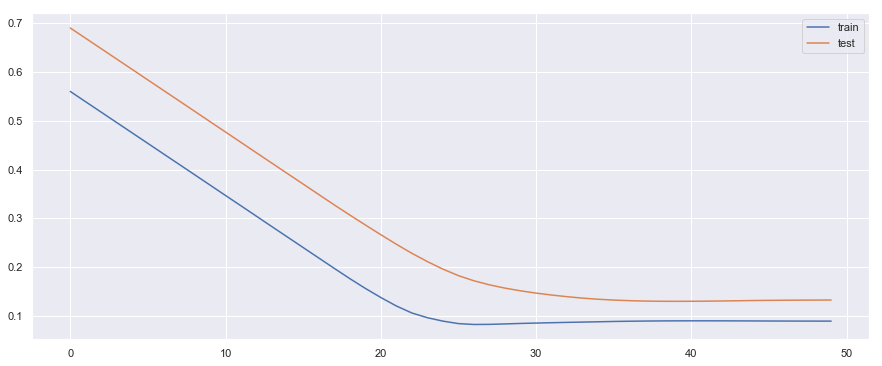

In [168]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [174]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat * (ma_max - ma_min) + ma_min
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y * (ma_max - ma_min) + ma_min
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2400677411.714


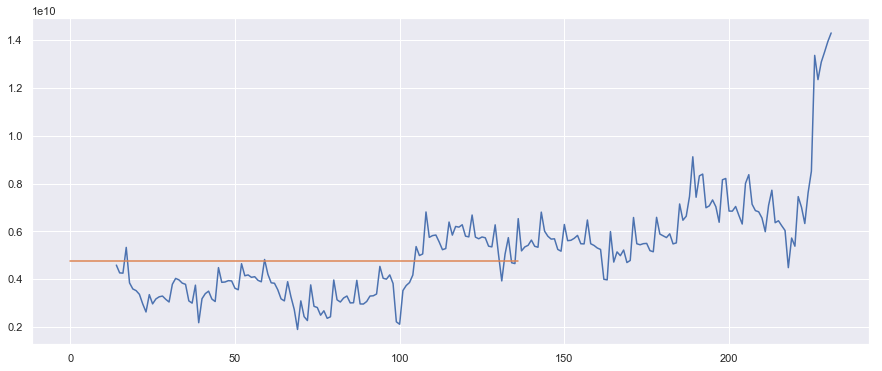

In [177]:
plt.plot(df_input_ph[['moving_avg']])
#plt.plot(trainPredictPlot)
plt.plot(inv_yhat)
plt.show()